# Combaring Different Combining Algorithms on Function Fitting

## Importing Required Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from polyKAN import KANLayer, combine_layers
import torch
import torch.nn as nn
import torch.optim as optim

### Create dataset

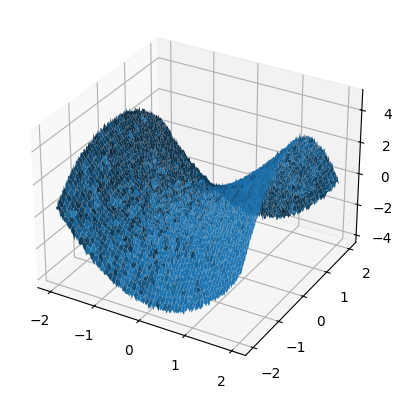

In [2]:
x1 = np.linspace(-2, 2, 200)
x2 = np.linspace(-2, 2, 200)
# create a grid of x1 and x2
X1, X2 = np.meshgrid(x1, x2)

# define the function
def func(x1, x2):
    z = np.sin(x1) * np.cos(x2) + x1**2 - x2**2
    # Add noise to z
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    return z

# call the function
Y = func(X1, X2)

# plot the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Y)
plt.show()



### Data Preprocessing

In [3]:
# create a dataset using x1 and x2 and the function
X = np.stack((X1.ravel(), X2.ravel()), axis=1)
Y = func(X1, X2).ravel()
print(X.shape, Y.shape)

(40000, 2) (40000,)


In [4]:
# training dataset is 80% of the data and the test dataset is 20% and use random points
n = X.shape[0]
n_train = int(0.8 * n)
n_test = n - n_train

# shuffle the data
np.random.seed(0)
indices = np.random.permutation(n)
X = X[indices]
Y = Y[indices]

X_train = X[:n_train]
Y_train = Y[:n_train]

X_test = X[n_train:]
Y_test = Y[n_train:]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32), 
    torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)  # Add this to match loss function
)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), 
    torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

## Creating Multiple Models

In [6]:
# define the model

class PolyNet(nn.Module):
    def __init__(self,poly_type):
        super(PolyNet, self).__init__()
        self.polynet = poly_type
        self.layer1 = KANLayer(2, 8,4,self.polynet,3,3)
        self.layer2 = KANLayer(8, 16,4,self.polynet,3,3)
        self.layer3 = KANLayer(16, 1,4,self.polynet,3,3)



    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
    

# create MLP model
class FCKAN(nn.Module):
    def __init__(self,poly_type1,poly_type2,combine_type):
        super(FCKAN, self).__init__()
        self.polynet1 = poly_type1
        self.polynet2 = poly_type2
        self.combine = combine_type
        self.layer1_1 = KANLayer(2, 8,4,self.polynet1,3,3)
        self.layer1_2 = KANLayer(2, 8,4,self.polynet2,3,3)
        self.layer2_1 = KANLayer(8, 16,4,self.polynet1,3,3)
        self.layer2_2 = KANLayer(8, 16,4,self.polynet2,3,3)
        self.layer3_1 = KANLayer(16, 1,4,self.polynet1,3,3)
        self.layer3_2 = KANLayer(16, 1,4,self.polynet2,3,3)


    def forward(self, g):
        x = self.layer1_1(g)
        y = self.layer1_2(g)
        x = self.layer2_1(x)
        y = self.layer2_2(y)
        x = self.layer3_1(x)
        y = self.layer3_2(y)
        z = combine_layers([x,y],method=self.combine)
        return z

In [7]:

chebyshev_model = PolyNet('chebyshev')
bessel_model = PolyNet('bessel')
sum_model = FCKAN('chebyshev','bessel','sum')
average_model = FCKAN('chebyshev','bessel','average')
product_model = FCKAN('chebyshev','bessel','product')
quadratic_model = FCKAN('chebyshev','bessel','quadratic')
weighted_model = FCKAN('chebyshev','bessel','weighted')

In [8]:

chebyshev_model.to(device)
bessel_model.to(device)
sum_model.to(device)
average_model.to(device)
product_model.to(device)
quadratic_model.to(device)
weighted_model.to(device)

chebyshev_model_params = sum(p.numel() for p in chebyshev_model.parameters() if p.requires_grad)
bessel_model_params = sum(p.numel() for p in bessel_model.parameters() if p.requires_grad)
sum_model_params = sum(p.numel() for p in sum_model.parameters() if p.requires_grad)
average_model_params = sum(p.numel() for p in average_model.parameters() if p.requires_grad)
product_model_params = sum(p.numel() for p in product_model.parameters() if p.requires_grad)
quadratic_model_params = sum(p.numel() for p in quadratic_model.parameters() if p.requires_grad)
weighted_model_params = sum(p.numel() for p in weighted_model.parameters() if p.requires_grad)

print(f"Chebyshev model trainable parameters: {chebyshev_model_params}")
print(f"bessel model trainable parameters: {bessel_model_params}")
print(f"Sum model trainable parameters: {sum_model_params}")
print(f"Average model trainable parameters: {average_model_params}")
print(f"Product model trainable parameters: {product_model_params}")
print(f"Quadratic model trainable parameters: {quadratic_model_params}")
print(f"Weighted model trainable parameters: {weighted_model_params}")


Chebyshev model trainable parameters: 800
bessel model trainable parameters: 800
Sum model trainable parameters: 1600
Average model trainable parameters: 1600
Product model trainable parameters: 1600
Quadratic model trainable parameters: 1600
Weighted model trainable parameters: 1600


## Training The Models

In [9]:

def train_model(model, train_loader, test_loader, epochs, name):
    train_losses = []
    test_losses = []
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
    criterion = nn.MSELoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print('Starting Training')
    print(f'==============={name}================')
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
            optimizer.step()
            total_train_loss += loss.item()
        
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                total_test_loss += loss.item()
        
        test_loss = total_test_loss / len(test_loader)
        test_losses.append(test_loss)
        
        scheduler.step(test_loss)  # Step the learning rate scheduler
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print('Finished Training')
    print(f'Epoch {epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses


epochs = 100


sum_train_losses, sum_test_losses = train_model(sum_model,train_loader,test_loader,epochs,'sum')
average_train_losses, average_test_losses = train_model(average_model,train_loader,test_loader,epochs, 'average')
product_train_losses, product_test_losses = train_model(product_model,train_loader,test_loader,epochs, 'product')
quadratic_train_losses, quadratic_test_losses = train_model(quadratic_model,train_loader,test_loader,epochs, 'quadratic')
weighted_train_losses, weighted_test_losses = train_model(weighted_model,train_loader,test_loader,epochs, 'weighted')
chebyshev_train_losses, chebyshev_test_losses = train_model(chebyshev_model,train_loader,test_loader,epochs,'chebyshev')
bessel_train_losses, bessel_test_losses = train_model(bessel_model,train_loader,test_loader,epochs,'bessel')




Starting Training
===============sum================
Epoch 1, Train Loss: 2.7512, Test Loss: 0.3639
Epoch 11, Train Loss: 0.0348, Test Loss: 0.0235
Epoch 21, Train Loss: 0.0583, Test Loss: 0.0740
Epoch 31, Train Loss: 0.0372, Test Loss: 0.0536
Epoch 41, Train Loss: 0.0250, Test Loss: 0.0425
Epoch 51, Train Loss: 0.0558, Test Loss: 0.0130
Epoch 61, Train Loss: 0.0396, Test Loss: 0.0904
Epoch 71, Train Loss: 0.0279, Test Loss: 0.0118
Epoch 81, Train Loss: 0.0174, Test Loss: 0.0509
Epoch 91, Train Loss: 0.0240, Test Loss: 0.0499
Finished Training
Epoch 100, Train Loss: 0.0135, Test Loss: 0.0115
Starting Training
===============average================
Epoch 1, Train Loss: 2.0412, Test Loss: 0.4930
Epoch 11, Train Loss: 0.0364, Test Loss: 0.0438
Epoch 21, Train Loss: 0.0274, Test Loss: 0.0378
Epoch 31, Train Loss: 0.0234, Test Loss: 0.0276
Epoch 41, Train Loss: 0.0182, Test Loss: 0.0240
Epoch 51, Train Loss: 0.0254, Test Loss: 0.0214
Epoch 61, Train Loss: 0.0165, Test Loss: 0.0212
Epoch 71,

/Users/mohammedahmed/Desktop/Project/KoopKAN/PolyKAN/polyKAN.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights_tensor = torch.tensor(weights, dtype=stacked_layers.dtype, device=stacked_layers.device)


Epoch 1, Train Loss: 1.0057, Test Loss: 0.3224
Epoch 11, Train Loss: 0.0449, Test Loss: 0.0415
Epoch 21, Train Loss: 0.0270, Test Loss: 0.0213
Epoch 31, Train Loss: 0.0226, Test Loss: 0.0177
Epoch 41, Train Loss: 0.0161, Test Loss: 0.0127
Epoch 51, Train Loss: 0.0143, Test Loss: 0.0133
Epoch 61, Train Loss: 0.0170, Test Loss: 0.0441
Epoch 71, Train Loss: 0.0280, Test Loss: 0.0135
Epoch 81, Train Loss: 0.0185, Test Loss: 0.0132
Epoch 91, Train Loss: 0.0136, Test Loss: 0.0105
Finished Training
Epoch 100, Train Loss: 0.0120, Test Loss: 0.0114
Starting Training
===============chebyshev================
Epoch 1, Train Loss: 1.9038, Test Loss: 0.3941
Epoch 11, Train Loss: 0.0118, Test Loss: 0.0118
Epoch 21, Train Loss: 0.0109, Test Loss: 0.0110
Epoch 31, Train Loss: 0.0105, Test Loss: 0.0104
Epoch 41, Train Loss: 0.0106, Test Loss: 0.0108
Epoch 51, Train Loss: 0.0105, Test Loss: 0.0108
Epoch 61, Train Loss: 0.0105, Test Loss: 0.0103
Epoch 71, Train Loss: 0.0103, Test Loss: 0.0104
Epoch 81, Tr

### Plotting The Results

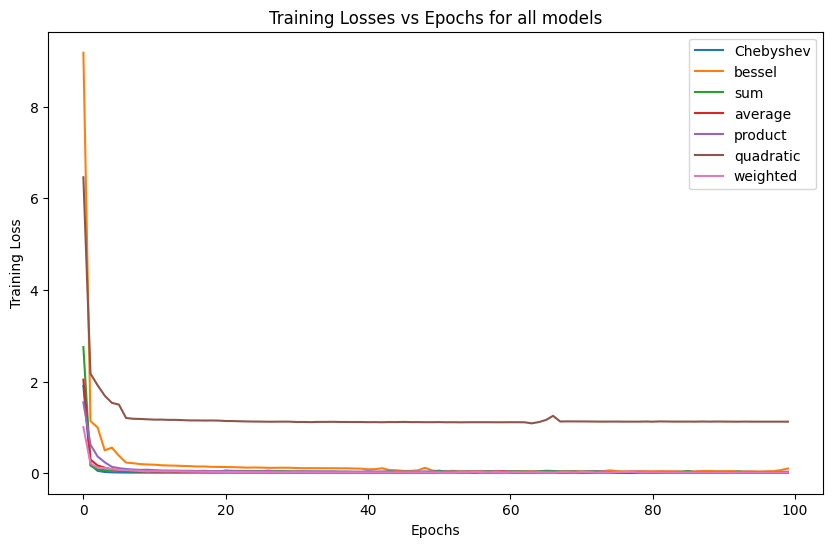

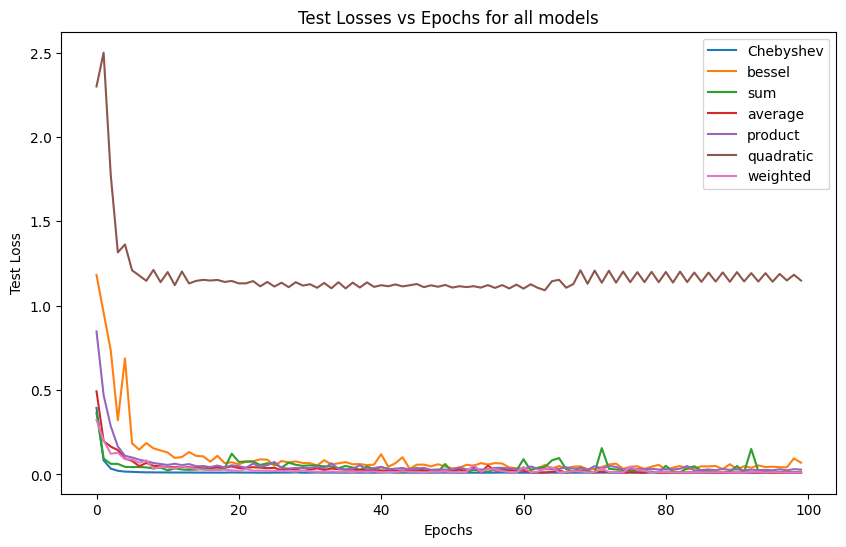

In [10]:
# plot the training losses against epochs for all models
plt.figure(figsize=(10, 6))
plt.plot(chebyshev_train_losses, label='Chebyshev')
plt.plot(bessel_train_losses, label='bessel')
plt.plot(sum_train_losses, label='sum')
plt.plot(average_train_losses, label='average')
plt.plot(product_train_losses, label='product')
plt.plot(quadratic_train_losses, label='quadratic')
plt.plot(weighted_train_losses, label='weighted')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Losses vs Epochs for all models')
plt.show()

# plot the test losses against epochs for all models
plt.figure(figsize=(10, 6))
plt.plot(chebyshev_test_losses, label='Chebyshev')
plt.plot(bessel_test_losses, label='bessel')
plt.plot(sum_test_losses, label='sum')
plt.plot(average_test_losses, label='average')
plt.plot(product_test_losses, label='product')
plt.plot(quadratic_test_losses, label='quadratic')
plt.plot(weighted_test_losses, label='weighted')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.title('Test Losses vs Epochs for all models')
plt.show()